In [1]:
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

In [2]:
import codecs
nltk.download('treebank')
nltk.download('universal_tagset')
# reading the Treebank tagged sentences with universal tagset

nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))
# first few tagged sentences

print(nltk_data[:40])
#set the random seed

random.seed(1234)

#Splitting into training and test sets
train_set, test_set = train_test_split(nltk_data,train_size=0.95)
#Get length of training and test sets
print(len(train_set))
print(len(test_set))

# Getting list of tagged words in training set
train_tagged_words = [tup for sent in train_set for tup in sent]

[nltk_data] Downloading package treebank to
[nltk_data]     C:\Users\student\AppData\Roaming\nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\student\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

C:\Users\student\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [3]:
# Get length of total tagged words in training set
len(train_tagged_words)

# tokens
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

# vocabulary
V = set(tokens)

print(len(V))
# number of pos tags in the training corpus
T = set([pair[1] for pair in train_tagged_words])
print(len(T))
print(T)
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))



12080
12
{'PRON', 'PRT', 'ADV', '.', 'NUM', 'DET', 'NOUN', 'ADJ', 'X', 'CONJ', 'ADP', 'VERB'}


In [4]:
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    return (count_w_given_tag, count_tag)

# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability
def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

# creating t x t (pos tags x pos tags)transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)
tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)):
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))
tags_df

,PRON,PRT,ADV,.,NUM,DET,NOUN,ADJ,X,CONJ,ADP,VERB
PRON,0.007350,0.012766,0.034429,0.040619,0.007350,0.009671,0.209671,0.075048,0.094778,0.005029,0.021277,0.482012
PRT,0.017653,0.001961,0.010134,0.043805,0.056228,0.101667,0.248120,0.084668,0.013730,0.001961,0.019941,0.400131
ADV,0.014990,0.013658,0.080280,0.136243,0.031646,0.069287,0.032312,0.125916,0.023318,0.006995,0.117921,0.347435
.,0.065419,0.002340,0.052821,0.092864,0.081796,0.171961,0.222802,0.044093,0.027535,0.057860,0.091155,0.089265
NUM,0.001476,0.027753,0.002657,0.118984,0.184824,0.002657,0.351639,0.032772,0.210216,0.013286,0.035430,0.018305
DET,0.003632,0.000242,0.012349,0.017433,0.022034,0.005569,0.638499,0.205811,0.045521,0.000484,0.009564,0.038862
NOUN,0.004779,0.043818,0.017002,0.239556,0.009668,0.013171,0.264256,0.012076,0.028640,0.042541,0.177059,0.147433
ADJ,0.000661,0.010907,0.004297,0.064617,0.020658,0.004793,0.701537,0.065774,0.020658,0.016691,0.077673,0.011734
X,0.054936,0.184395,0.025955,0.163853,0.002866,0.055414,0.062580,0.017038,0.073885,0.009873,0.144745,0.204459
CONJ,0.057944,0.005140,0.053271,0.035981,0.041589,0.116355,0.350467,0.117290,0.008411,0.000000,0.055607,0.157944


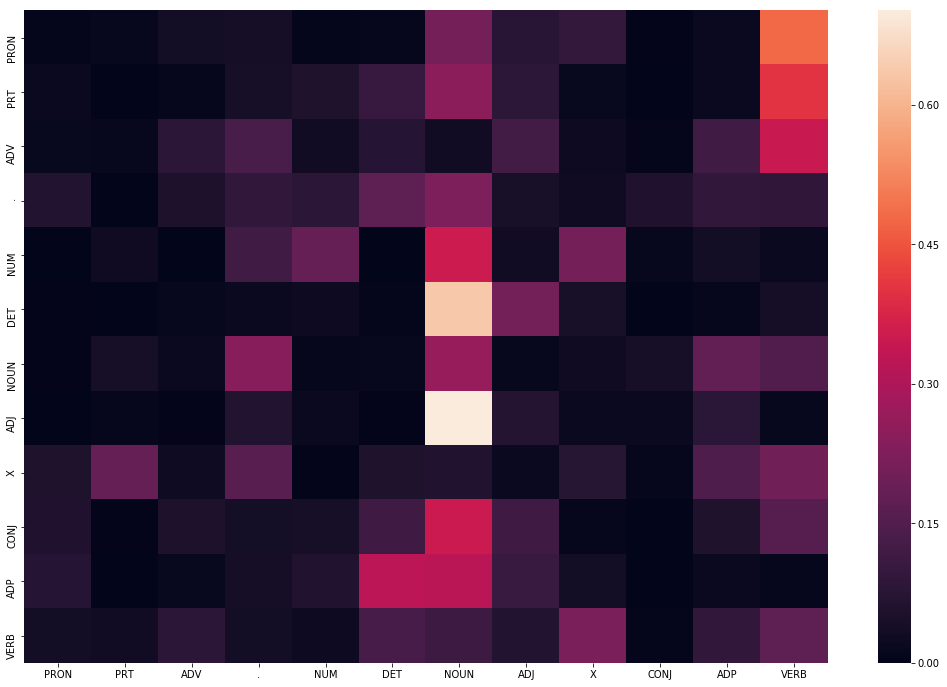

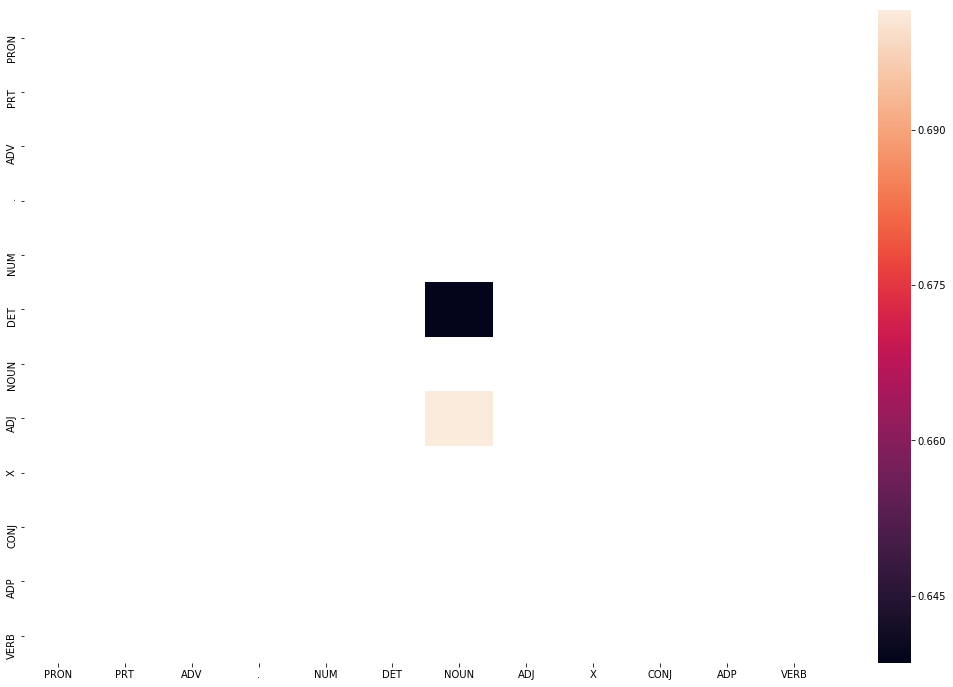

95560

In [5]:
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()
len(train_tagged_words)

In [8]:
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    for key, word in enumerate(words):
        p = []
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p   
            p.append(state_probability)
        pmax = max(p)

        # getting state for which probability is maximum
        state_max = T[p.index(pmax)]
        state.append(state_max)
    return list(zip(words, state))

In [9]:
# Viterbi Heuristic
test_run_base = [tup for sent in test_set for tup in sent]
test_tagged_words = [tup[0] for sent in test_set for tup in sent]
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start
print(difference)
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j]
accuracy = len(check)/len(tagged_seq)
print(accuracy)

517.4119191169739
0.9028537920250196
